In [1]:
import pickle 
import os
import torch
import os.path


In [2]:
# %%writefile merge.py
# import argparse
# import os

# parser = argparse.ArgumentParser("dot")
# parser.add_argument("dataset_folder", help="Path to a dataset folder of .train files that can be read by calling load_dataset('text', <path>)")
# parser.add_argument("model_dir", help="Where the model and checkpoints are stored")
# parser.add_argument("gradient_input_dir", help="Where the gradients are stored")
# parser.add_argument("influence_output_dir", help="Where the influence scores should be stored")

# parser.add_argument("--num_processes", help="Number of processes to use (one model per process)", type=int, nargs="?", const=1, default=10)
# parser.add_argument("--cuda_visible_devices", help="Comma seperated GPU ids to use", nargs="?", const=1, default="0,1")
# parser.add_argument("--gradients_per_file", help="Number of gradients per output file", type=int, nargs="?", const=1, default=10000)
# args = parser.parse_args()

# if not os.path.exists(args.influence_output_dir):
#     os.makedirs(args.influence_output_dir)

# os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda_visible_devices
# os.environ["TOKENIZERS_PARALLELISM"] = "False"

# import traceback

# import torch 
# import time
# def run(chunk_path_a, start_id_a, stop_id_a, subtasks):

#     # from tqdm import tqdm

#     device = "cpu"
    
#     try:
#         with torch.no_grad():
#             start_time = time.time()
#             chunk_a = torch.load(chunk_path_a, weights_only=True,map_location=device).flatten(1)
#             print(f"Time to load chunk_a: {time.time() - start_time:.4f} seconds", flush=True)
#             result = torch.zeros((chunk_a.shape[0])).to(device)
#             for chunk_path_b,start_id_b, stop_id_b in  tqdm(subtasks, leave=False):
#                 chunk_b = torch.load(chunk_path_b, weights_only=True,map_location=device).flatten(1)
#                 start_time = time.time()
#                 result  += torch.einsum('ik, kj -> i', chunk_a, chunk_b.T)
#                 print(f"Time to einsum: {time.time() - start_time:.4f} seconds", flush=True)
#             return (start_id_a, stop_id_a, result)

#     except Exception as e:
#         print(traceback.format_exc(),flush=True)
#         raise e

# from multiprocessing import Pool, current_process
# import time 
# import datetime
# import os
# from pathlib import Path
# import torch
# from itertools import cycle



# from multiprocessing import Pool,Queue,Manager
# import multiprocessing as mp

# if __name__ == '__main__':
#     # mp.set_start_method('fork')

#     from transformers import RobertaConfig,AutoConfig
#     from transformers import RobertaForMaskedLM
#     import torch
#     from tqdm import tqdm
#     from transformers import RobertaTokenizerFast
#     from transformers import DataCollatorForLanguageModeling
#     tokenizer = RobertaTokenizerFast.from_pretrained(args.model_dir, max_len=512)
#     data_collator = DataCollatorForLanguageModeling(
#         tokenizer=tokenizer, mlm=True, mlm_probability=0.15
#     )
#     from datasets import load_dataset
#     dataset = load_dataset("text", data_dir=args.dataset_folder)
#     dataset.set_transform(lambda x : tokenizer(x["text"], return_special_tokens_mask=True, truncation=True, padding="max_length", max_length=512))


    
#     def get_all_chunks(checkpoint_path):
#         # return [ os.path.join(args.gradient_input_dir, checkpoint_path.split("-")[-1] + "_" + str(i) + "_" + str(i + args.gradients_per_file)) for i in range(0, len(dataset["train"]), args.gradients_per_file)]
#         return [str(x) for x in Path(args.gradient_input_dir).glob("*")]






#     with Pool(args.num_processes) as p:
#         from util import get_epoch_checkpoints
#         checkpoints = [str(x) for x in Path(args.model_dir).glob("checkpoint-*") if int(str(x).split("-")[-1]) in get_epoch_checkpoints(args.model_dir)]
        
#         for checkpoint_path in tqdm(checkpoints, desc="Running for checkpoints", leave=False):
#             result_checkpoint = torch.zeros((len(dataset["train"])))
#             out_path = os.path.join(args.influence_output_dir, checkpoint_path.split("-")[-1])
#             if os.path.isfile(out_path):
#                 True
#                 continue

#             tasks = []
#             for chunk_path_a in get_all_chunks(checkpoint_path):
#                 _, start_id_a, stop_id_a = chunk_path_a.split( "_")
#                 start_id_a = int(start_id_a)
#                 stop_id_a = int(stop_id_a)
#                 subtasks = []
#                 for chunk_path_b in get_all_chunks(checkpoint_path):
#                     _, start_id_b, stop_id_b = chunk_path_b.split( "_")
#                     start_id_b = int(start_id_b)
#                     stop_id_b = int(stop_id_b)
#                     subtasks.append((chunk_path_b,start_id_b, stop_id_b))
#                 tasks.append((chunk_path_a, start_id_a, stop_id_a, subtasks))
#             tasks = tasks[0:1000]
#             r = p.starmap(run, tasks )
#             for start_id_a, _, rr in r:
#                 result_checkpoint[start_id_a:start_id_a + rr.shape[0]] += rr #  the stop_ids are taken from the task description in if.ipynb and can therefore be higher than the actual lenght
#             result_checkpoint = (result_checkpoint / len(dataset["train"])).unsqueeze(0)   
#             torch.save(result_checkpoint, out_path)


In [3]:
%%writefile merge.py
import argparse
import os

parser = argparse.ArgumentParser("dot")
parser.add_argument("dataset_folder", help="Path to a dataset folder of .train files that can be read by calling load_dataset('text', <path>)")
parser.add_argument("model_dir", help="Where the model and checkpoints are stored")
parser.add_argument("gradient_input_dir", help="Where the gradients are stored")
parser.add_argument("influence_output_dir", help="Where the influence scores should be stored")

parser.add_argument("--num_processes", help="Number of processes to use (one model per process)", type=int, nargs="?", const=1, default=4)
parser.add_argument("--cuda_visible_devices", help="Comma seperated GPU ids to use", nargs="?", const=1, default="0,1")
parser.add_argument("--gradients_per_file", help="Number of gradients per output file", type=int, nargs="?", const=1, default=10000)
parser.add_argument("--batch_size", help="How many chunks each subprocess will keep in memory", type=int, nargs="?", const=1, default=20)
args = parser.parse_args()

if not os.path.exists(args.influence_output_dir):
    os.makedirs(args.influence_output_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda_visible_devices
os.environ["TOKENIZERS_PARALLELISM"] = "False"

import traceback

import logging
logging.basicConfig(filename="merge.log",
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

import torch 
import time
def run(tasks, subtasks):

    # from tqdm import tqdm

    device = "cpu"
    
    try:
        with torch.no_grad():
            start_time = time.time()
            try:
                chunks_a = [torch.load(chunk_path_a, weights_only=True,map_location=device).flatten(1) for (chunk_path_a,start_id_a, stop_id_a) in tasks]
            except:
                logging.error("{} seems corrupted (recompute!)".format(tasks) ) # this happens if the gradient extraction script was killed during torch.save
                return None
            logging.info(f"Time to load task: {time.time() - start_time:.4f} seconds")
            results = [torch.zeros((chunk_a.shape[0])).to(device) for chunk_a in chunks_a]
            start_time = time.time()
            for chunk_path_b,start_id_b, stop_id_b in subtasks:
                try:
                    chunk_b = torch.load(chunk_path_b, weights_only=True,map_location=device).flatten(1)
                except:
                    # this happens if the gradient extraction script was killed during torch.save
                    logging.error("{} seems corrupted (recompute!)".format(chunk_path_b) )
                    return None
                for i, chunk_a in enumerate(chunks_a):
                    results[i]  += torch.einsum('ik, kj -> i', chunk_a, chunk_b.T)
            logging.info(f"Time to einsum: {time.time() - start_time:.4f} seconds; {(time.time() - start_time)/len(subtasks):.4f} s/chunk")

            return (tasks, results)

    except Exception as e:
        print(traceback.format_exc(),flush=True)
        raise e

from multiprocessing import Pool, current_process
import time 
import datetime
import os
from pathlib import Path
import torch
from itertools import cycle



from multiprocessing import Pool,Queue,Manager
import multiprocessing as mp

if __name__ == '__main__':
    # mp.set_start_method('fork')

    from transformers import RobertaConfig,AutoConfig
    from transformers import RobertaForMaskedLM
    import torch
    from tqdm import tqdm
    from transformers import RobertaTokenizerFast
    from transformers import DataCollatorForLanguageModeling
    tokenizer = RobertaTokenizerFast.from_pretrained(args.model_dir, max_len=512)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )
    from datasets import load_dataset
    dataset = load_dataset("text", data_dir=args.dataset_folder)
    dataset.set_transform(lambda x : tokenizer(x["text"], return_special_tokens_mask=True, truncation=True, padding="max_length", max_length=512))

    def batch(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
        
    def get_all_chunks(checkpoint_path):
        return [ os.path.join(args.gradient_input_dir, checkpoint_path.split("-")[-1] + "_" + str(i) + "_" + str(i + args.gradients_per_file)) for i in range(0, len(dataset["train"]), args.gradients_per_file)]
        
        #return [str(x) for x in Path(checkpoint_path).glob("*")]






    with Pool(args.num_processes) as p:
        from util import get_epoch_checkpoints
        checkpoints = [str(x) for x in Path(args.model_dir).glob("checkpoint-*") if int(str(x).split("-")[-1]) in get_epoch_checkpoints(args.model_dir)]
        
        for checkpoint_path in tqdm(checkpoints, desc="Running for checkpoints", leave=False):
            result_checkpoint = torch.zeros((len(dataset["train"])))
            out_path = os.path.join(args.influence_output_dir, checkpoint_path.split("-")[-1])
            if os.path.isfile(out_path):
                continue

            jobs = []
            
            # tasks = []
            # for chunk_path_a in get_all_chunks(checkpoint_path):
            #     _, start_id_a, stop_id_a = chunk_path_a.split( "_")
            #     start_id_a = int(start_id_a)
            #     stop_id_a = int(stop_id_a)
            #     tasks.append((chunk_path_a, start_id_a, stop_id_a))

            print("that many chunks in this checkpoint:", len(get_all_chunks(checkpoint_path)), flush=True)
            subtasks = []
            for chunk_path_b in get_all_chunks(checkpoint_path):
                _, start_id_b, stop_id_b = chunk_path_b.split( "_")
                start_id_b = int(start_id_b)
                stop_id_b = int(stop_id_b)
                subtasks.append((chunk_path_b,start_id_b, stop_id_b))
           # subtasks = subtasks[0:100]
            for tasks in batch(subtasks, args.batch_size):
                jobs.append((tasks, subtasks))
            #jobs = jobs[0:1]
            
            # exit
            r = p.starmap(run, jobs )
            for rr in r:
                for task, result in zip(*rr):
                    chunk_path_a, start_id_a, stop_id_a = task
                    result_checkpoint[start_id_a:(start_id_a + result.shape[0])] += result #  the stop_ids are taken from the task description in if.ipynb and can therefore be higher than the actual lenght
            result_checkpoint = (result_checkpoint / len(dataset["train"])).unsqueeze(0)   
            torch.save(result_checkpoint, out_path)
            logging.info("Saved {}".format(out_path))

Overwriting merge.py


In [4]:
# %run merge.py ./train_10M ./10MModel ./gradients ./influence

## Create New Curriculum

In [33]:
args = {
    "dataset_folder": "./train_10M",
    "model_dir": "./10MModel",
    "influence_output_dir": "./influence",
    "curriculum_output_folder": "./10MCurriculum"
}

In [34]:
from pathlib import Path

from datasets import load_dataset
dataset = load_dataset("text", data_dir=args["dataset_folder"])
#dataset.set_transform(lambda x : tokenizer(x["text"], return_special_tokens_mask=True, truncation=True, padding="max_length", max_length=512))

((len(dataset["train"]) / 10000) / 10)*7

82.53098

In [35]:
import pandas as  pd
import os
import torch
import numpy as np
# pd.DataFrame(a)

In [36]:
if not os.path.exists(args["curriculum_output_folder"]):
    os.makedirs(args["curriculum_output_folder"])

In [37]:

df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(args["influence_output_dir"],result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(args["influence_output_dir"])})
# df = df.rename({0: "influence"}, axis=1)
df.sort_index(axis=1)

STAGES = list(df.columns)
NUM_STAGES = len(STAGES)

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
df["total"] = df.sum(axis=1)
df["text"] = dataset["train"].to_pandas()
df

,147372,294744,442116,589488,736890,total,text
0,0.000000,0.037738,0.019859,0.000000,0.000000,0.057597,Yeah.
1,0.003549,-0.010743,-0.005466,-0.039779,-0.015005,-0.067444,"Compound's things like six nine, six nine erm"
2,0.000000,0.072390,0.000000,0.000000,0.000000,0.072390,Nine twelve
3,0.017596,-0.096948,0.000000,0.000000,-0.025752,-0.105104,Yeah.
4,0.000000,0.149858,0.024957,0.016082,-0.037466,0.153431,That sort of stuff.
...,...,...,...,...,...,...,...
1179009,0.000000,-0.024962,0.000000,0.000000,0.044522,0.019560,B:\tThat's right.
1179010,0.001755,0.012571,0.000000,0.015193,0.008095,0.037613,"A:\tAnd, and the schools don't, don't really e..."
1179011,-0.000662,0.063342,-0.001960,0.018885,0.007200,0.086805,A:\tthe schools are there to teach history and...
1179012,0.003105,-0.051077,-0.002226,0.000057,0.121816,0.071675,A:\tThey don't teach them good values like dru...


In [38]:
df[17990:]

,147372,294744,442116,589488,736890,total,text
17990,0.000000,-0.004956,0.032512,0.000000,0.000000,0.027556,Do you remember me mentioning that?
17991,0.002076,-0.050345,-0.009025,0.003409,-0.005722,-0.059607,"And it's trying to pull the planets in, Lee, b..."
17992,-0.000364,0.010737,-0.000986,0.009887,0.011799,0.031072,All different distances away from the sun and ...
17993,0.000039,-0.116862,-0.005645,-0.035607,0.006941,-0.151134,"All going round in, what's the word again?"
17994,0.000000,0.046302,0.000000,0.000000,0.000000,0.046302,Orbit.
...,...,...,...,...,...,...,...
1179009,0.000000,-0.024962,0.000000,0.000000,0.044522,0.019560,B:\tThat's right.
1179010,0.001755,0.012571,0.000000,0.015193,0.008095,0.037613,"A:\tAnd, and the schools don't, don't really e..."
1179011,-0.000662,0.063342,-0.001960,0.018885,0.007200,0.086805,A:\tthe schools are there to teach history and...
1179012,0.003105,-0.051077,-0.002226,0.000057,0.121816,0.071675,A:\tThey don't teach them good values like dru...


In [39]:
NUM_DOCS_STAGE = len(df) // NUM_STAGES
NUM_DOCS_STAGE

235802

In [40]:
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm

In [41]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
size=len(STAGES)
print(size)
def gaussian_filter(size, **args):
    print(args)
    indices = np.arange(-size, size+1, 1)
    weights =  norm.pdf(indices, **args)
    return weights# / np.sum(weights)


def f_filter(size, **args):
    print(args)
    indices = np.arange(-size, size+1, 1)
    print(indices)
    weights = f.pdf(indices+1, **args)
    return weights# / np.sum(weights)
def lognorm_filter(size, **args):
    #print(args)
    indices = np.arange(-size, size+1, 1)
    #print(indices)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)




5


In [42]:
# filter_weights = f_filter(size, dfn=15, dfd=3)
# print(filter_weights)
# plt.plot(np.arange(-size,size, 1),filter_weights)
# plt.vlines(0, ymin=0, ymax=max(filter_weights)+0.1, colors=["red"])

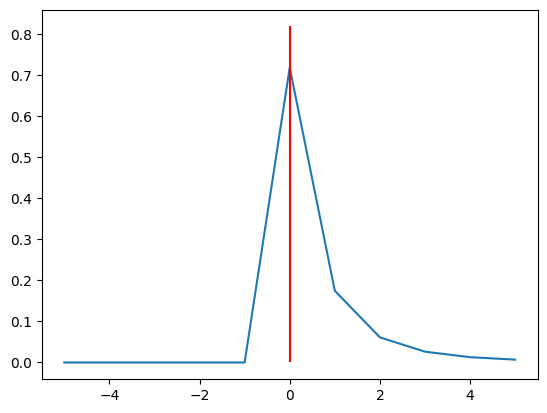

In [43]:

filter_weights = lognorm_filter(size, s=1, loc=0, scale=0.5)
plt.plot(np.arange(-size,size+1, 1),filter_weights)
plt.vlines([0], ymin=0, ymax=max(filter_weights)+0.1, colors=["red"])


In [44]:
filter_weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.7181104 , 0.17465221, 0.06113207, 0.02627235, 0.01289014,
       0.00694283])

In [45]:
NUM_STAGES

5

In [46]:
a = [1000,10,1,]
np.convolve(a,filter_weights, mode="full")

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.18110404e+02, 1.81833313e+02, 6.35966987e+01,
       2.70583189e+01, 1.32139979e+01, 7.09800626e+00, 8.23184673e-02,
       6.94283249e-03])

In [47]:
n = df[STAGES].to_numpy()#[0:1000,:]
scores = np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=n)
scores.shape

(1179014, 5)

In [48]:
df_usefulness = df.copy()
df_usefulness[STAGES] = np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=n)
df_usefulness["total"] = df_usefulness[STAGES].sum(axis=1)

In [49]:
df.sort_values(by="total", ascending=False)

,147372,294744,442116,589488,736890,total,text
643494,0.165543,2.265923,0.524465,0.286805,0.229043,3.471779,*CHI:\txxx there.
244811,0.362952,2.299466,0.286687,0.168847,0.350702,3.468653,*CHI:\tyeah.
381475,0.040605,2.270147,0.456249,0.251320,0.343483,3.361804,*CHI:\tyeah.
638797,0.187798,2.230774,0.387323,0.213708,0.293097,3.312700,*INV:\tmhm.
615606,0.169494,2.267915,0.252652,0.233165,0.332394,3.255619,*CHI:\tMummy.
...,...,...,...,...,...,...,...
1025259,0.010595,-0.859355,-0.153742,-0.011590,0.000000,-1.014093,it's ridiculous.
783976,-0.022037,-0.747016,-0.047183,0.000000,-0.207160,-1.023396,-Ever driven a tank?
982432,0.000000,-0.925788,-0.052338,0.015549,-0.079857,-1.042435,How about your egg?
916155,-0.009866,-0.890340,-0.135603,-0.063575,0.000000,-1.099384,What a pity!


In [50]:
df_usefulness = df_usefulness.sort_values(by="total", ascending=False)
df_usefulness

,147372,294744,442116,589488,736890,total,text
643494,0.348998,1.627183,0.772372,0.326463,0.267676,3.342692,*CHI:\txxx there.
244811,0.451281,1.651270,0.607479,0.262579,0.340693,3.313303,*CHI:\tyeah.
381475,0.247623,1.630216,0.724123,0.275101,0.334284,3.211347,*CHI:\tyeah.
638797,0.338878,1.601942,0.667750,0.268551,0.298212,3.175333,*INV:\tmhm.
247635,0.446351,1.647278,0.570710,0.264793,0.198039,3.127170,*JUD:\twatch!
...,...,...,...,...,...,...,...
1061248,-0.107233,-0.597678,-0.198351,-0.076277,-0.009926,-0.989465,Adam's right.
1025259,-0.071777,-0.617112,-0.260492,-0.038448,-0.016493,-1.004323,it's ridiculous.
982432,-0.065736,-0.664818,-0.199275,-0.016356,-0.067939,-1.014126,How about your egg?
916155,-0.085197,-0.639363,-0.252878,-0.079058,-0.026746,-1.083241,What a pity!


In [51]:
df_usefulness.sort_values(by=STAGES[0], ascending=False)[0:NUM_DOCS_STAGE]

,147372,294744,442116,589488,736890,total,text
409438,0.198016,1.724423,0.630238,0.318757,0.096482,2.967916,*MOT:\tis that good?
153133,0.233419,1.710726,0.604814,0.193205,0.208425,2.950588,*CHI:\tah.
249736,0.398891,1.668298,0.621068,0.227053,0.192791,3.108100,*CHI:\tI got it!
244811,0.451281,1.651270,0.607479,0.262579,0.340693,3.313303,*CHI:\tyeah.
658479,0.184689,1.651128,0.411150,0.327705,0.280443,2.855116,*CHI:\tpardon?
...,...,...,...,...,...,...,...
351587,0.061610,0.323774,0.088000,0.028386,0.134291,0.636061,*GRA:\tthis is delicious.
244130,0.251017,0.323774,0.082057,0.064870,0.066667,0.788385,*MOT:\tyou know where it is.
564182,0.050459,0.323768,0.172888,0.020418,0.090553,0.658087,*MOT:\t[laughs].
604447,0.069583,0.323766,0.078743,0.022065,0.009389,0.503546,*CHI:\tno.


In [52]:

df_usefulness_ = df_usefulness.copy()
for stage in STAGES:
    pd.concat([df_usefulness_,df_usefulness.sort_values(by=STAGES[1], ascending=False)]).drop_duplicates(keep="first")[0:2*NUM_DOCS_STAGE]

In [53]:
df_usefulness

,147372,294744,442116,589488,736890,total,text
643494,0.348998,1.627183,0.772372,0.326463,0.267676,3.342692,*CHI:\txxx there.
244811,0.451281,1.651270,0.607479,0.262579,0.340693,3.313303,*CHI:\tyeah.
381475,0.247623,1.630216,0.724123,0.275101,0.334284,3.211347,*CHI:\tyeah.
638797,0.338878,1.601942,0.667750,0.268551,0.298212,3.175333,*INV:\tmhm.
247635,0.446351,1.647278,0.570710,0.264793,0.198039,3.127170,*JUD:\twatch!
...,...,...,...,...,...,...,...
1061248,-0.107233,-0.597678,-0.198351,-0.076277,-0.009926,-0.989465,Adam's right.
1025259,-0.071777,-0.617112,-0.260492,-0.038448,-0.016493,-1.004323,it's ridiculous.
982432,-0.065736,-0.664818,-0.199275,-0.016356,-0.067939,-1.014126,How about your egg?
916155,-0.085197,-0.639363,-0.252878,-0.079058,-0.026746,-1.083241,What a pity!


### With convolution

In [61]:
df_usefulness_ = df_usefulness.copy()
dfs_selection = []
for stage in STAGES:
    dfs_selection.append(df_usefulness_.nlargest(NUM_DOCS_STAGE, columns=stage))
    df_usefulness_ = df_usefulness_.nsmallest(len(df_usefulness_) - NUM_DOCS_STAGE, columns=stage)
 
print(len(df_usefulness_))
for stage_id, d in enumerate(dfs_selection):
    print(os.path.join(args["curriculum_output_folder"],"{}.train".format(stage_id)))
    with open(os.path.join(args["curriculum_output_folder"],"{}.train".format(stage_id)), "w") as f:
        for line in d["text"]:
            f.write(line + "\n") 
    display(d)
    

4
./10MCurriculum/0.train


,147372,294744,442116,589488,736890,total,text
409438,0.198016,1.724423,0.630238,0.318757,0.096482,2.967916,*MOT:\tis that good?
153133,0.233419,1.710726,0.604814,0.193205,0.208425,2.950588,*CHI:\tah.
249736,0.398891,1.668298,0.621068,0.227053,0.192791,3.108100,*CHI:\tI got it!
244811,0.451281,1.651270,0.607479,0.262579,0.340693,3.313303,*CHI:\tyeah.
658479,0.184689,1.651128,0.411150,0.327705,0.280443,2.855116,*CHI:\tpardon?
...,...,...,...,...,...,...,...
351587,0.061610,0.323774,0.088000,0.028386,0.134291,0.636061,*GRA:\tthis is delicious.
244130,0.251017,0.323774,0.082057,0.064870,0.066667,0.788385,*MOT:\tyou know where it is.
564182,0.050459,0.323768,0.172888,0.020418,0.090553,0.658087,*MOT:\t[laughs].
604447,0.069583,0.323766,0.078743,0.022065,0.009389,0.503546,*CHI:\tno.


./10MCurriculum/1.train


,147372,294744,442116,589488,736890,total,text
388982,0.148537,0.293484,0.395106,0.090185,0.030896,0.958207,*CHI:\thuh?
380780,0.094873,0.313532,0.390426,0.036215,0.016422,0.851467,*UNK:\tMichael.
641263,0.102524,0.319794,0.387388,0.032730,0.015772,0.858208,*CHI:\toh dear.
638055,0.149364,0.304318,0.381764,0.053732,0.021973,0.911152,*MOT:\twhere?
647327,0.100701,0.307478,0.381204,0.037335,0.147543,0.974260,*MOT:\tah.
...,...,...,...,...,...,...,...
995286,0.012582,0.065266,0.044762,0.016839,-0.000072,0.139377,"I'm sorry, this will hurt a little."
65259,0.015989,0.196408,0.044762,0.004317,0.000336,0.261812,If you add X to minus X
1153694,0.018342,0.286999,0.044762,0.070767,0.069129,0.489999,Shrines and Temples.
207220,0.012621,0.048275,0.044762,0.005549,0.002076,0.113282,"*MOT:\tI don't understand you, honey, what's s..."


./10MCurriculum/2.train


,147372,294744,442116,589488,736890,total,text
248842,0.296025,0.177004,0.043049,0.090022,0.049955,0.656055,*CHI:\tno.
246467,0.279646,0.159793,0.036602,0.070492,0.025480,0.572013,*CHI:\the run away.
244407,0.279418,0.178131,0.043323,0.070786,0.025693,0.597352,*CLA:\tis that right?
737554,0.279229,0.112296,0.027312,0.069695,0.024972,0.513505,LEO:
248158,0.278727,0.046376,0.011279,0.068526,0.001720,0.406627,"*RUS:\twhat ya got there, crazy man?"
...,...,...,...,...,...,...,...
1055641,0.007338,0.043669,0.022543,-0.003600,-0.000209,0.069741,"Jim, nice to see they're keeping the chief of ..."
895110,0.007338,0.019279,0.001545,0.013056,0.002863,0.044081,And there was no hot water.
638574,0.007338,0.086194,0.020963,0.003153,0.068713,0.186362,*CHI:\tapple.
947321,0.007338,0.044824,0.010902,0.002496,0.001104,0.066664,- Karen.


./10MCurriculum/3.train


,147372,294744,442116,589488,736890,total,text
324019,-0.003157,0.099465,0.001233,0.292945,0.059432,0.449917,*GRA:\tI'm standing up Steven.
577632,-0.026011,0.119227,0.028997,0.273869,0.102836,0.498918,*FAT:\tyou tired?
314577,0.004892,0.149775,0.036427,0.214920,0.050228,0.456242,"*MOT:\tcome on, Daddy!"
317813,0.006988,0.108043,0.026403,0.190953,0.105335,0.437722,*MOT:\tthat's not what it's for.
572267,0.005724,0.167719,0.029975,0.186045,0.046441,0.435905,"*BRO:\tokay, whatever."
...,...,...,...,...,...,...,...
1071860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ALISE:
27351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,yeah
27352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,To buy one
27355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Did they?


./10MCurriculum/4.train


,147372,294744,442116,589488,736890,total,text
636162,0.004422,-0.041936,0.022661,-0.019826,0.230584,0.195906,*MOT:\tstart again.
551641,0.002939,0.140054,0.034063,-0.015781,0.230119,0.391393,*FRI:\tmines a bit.
496354,-0.012961,0.011323,0.000134,-0.020873,0.218528,0.196152,"*FAT:\tyes, darling."
592096,-0.002066,0.033450,0.007103,-0.003557,0.217346,0.252277,*MOT:\twell you can just do it xxx.
390930,0.006011,0.124739,0.027065,-0.001517,0.202122,0.358420,*MOT:\tand that one.
...,...,...,...,...,...,...,...
25635,-0.077832,-0.238079,-0.057903,-0.022711,-0.143044,-0.539569,Is he?
944770,-0.024292,-0.298051,-0.068044,-0.016372,-0.145931,-0.552690,I honestly thought she was joking.
824028,-0.015081,-0.177154,-0.043086,-0.079255,-0.146137,-0.460713,–Yeah?
753227,-0.010273,-0.202350,-0.041606,-0.008552,-0.151623,-0.414405,"Well,she must be a very cool lady."


In [55]:
from datasets import load_dataset
dataset_c = load_dataset("text", data_dir=args["curriculum_output_folder"])

Generating train split: 1182010 examples [00:00, 1618165.93 examples/s]


In [56]:
# assert all([t in dataset["train"]["text"] for t in dataset_c["train"]["text"]])

In [57]:
dataset_c["train"][0]["text"] in dataset["train"]["text"]

True

### No convolution

In [58]:
df_usefulness_ = df.copy()
dfs_selection = []
for stage in STAGES:
    dfs_selection.append(df_usefulness_.nlargest(NUM_DOCS_STAGE, columns=stage))
    df_usefulness_ = df_usefulness_.nsmallest(len(df_usefulness_) - NUM_DOCS_STAGE, columns=stage)
    print(len(df_usefulness_))
print(len(df_usefulness_))
for a in dfs_selection:
    display(a)

943212
707410
471608
235806
4
4


,147372,294744,442116,589488,736890,total,text
409438,-0.000084,2.401334,0.293604,0.331055,0.000000,3.025909,*MOT:\tis that good?
153133,0.058321,2.382260,0.262838,0.145331,0.197552,3.046302,*CHI:\tah.
249736,0.284778,2.323177,0.299842,0.136401,0.158381,3.202579,*CHI:\tI got it!
244811,0.362952,2.299466,0.286687,0.168847,0.350702,3.468653,*CHI:\tyeah.
658479,0.058210,2.299268,0.013338,0.356932,0.257005,2.984751,*CHI:\tpardon?
...,...,...,...,...,...,...,...
351587,0.044278,0.450870,0.012887,0.011167,0.171956,0.691158,*GRA:\tthis is delicious.
244130,0.310048,0.450869,0.004612,-0.001960,0.058658,0.822227,*MOT:\tyou know where it is.
564182,0.000000,0.450862,0.131100,0.000778,0.113020,0.695760,*MOT:\t[laughs].
604447,0.058516,0.450858,0.000000,0.000000,0.000000,0.509374,*CHI:\tno.


,147372,294744,442116,589488,736890,total,text
388982,0.062413,0.408689,0.450805,0.057078,0.000000,0.978984,*CHI:\thuh?
380780,-0.011458,0.436607,0.437497,0.000000,0.000000,0.862647,*UNK:\tMichael.
641263,0.000000,0.445327,0.431146,-0.007417,0.000000,0.869056,*CHI:\toh dear.
638055,0.067690,0.423777,0.428557,0.006374,0.000000,0.926398,*MOT:\twhere?
647327,0.000000,0.428177,0.426706,0.000000,0.182163,1.037045,*MOT:\tah.
...,...,...,...,...,...,...,...
1165291,0.002140,0.030287,0.012199,0.019122,0.029043,0.092791,"B:\tYou know, one thing you might do with, in ..."
341672,0.002299,0.362423,0.012199,0.069979,0.164988,0.611887,*PAR:\tyou watch Spongebob tell me about Spong...
769861,0.004482,0.031358,0.012199,0.024391,0.001980,0.074411,I'm done listening to your going-up shit.
39257,0.000285,0.017096,0.012199,0.002028,0.001293,0.032902,"Can you, yeah go on no you hold my hand pleas..."


,147372,294744,442116,589488,736890,total,text
243029,0.406379,0.264103,0.000000,0.000000,0.000000,0.670482,*JJJ:\tyeah.
482891,0.405981,0.325869,0.004809,-0.000077,0.004814,0.741395,*MOT:\tthat's a funny monkey isn't he?
211349,0.401367,0.385517,0.000169,-0.000262,0.009240,0.796031,*FAT:\tpurple snow?
240519,0.397188,0.343288,0.003851,0.003383,0.091711,0.839421,*CHI:\teven I got a scratch on that one too.
242542,0.395685,0.260697,0.000000,0.000000,0.017187,0.673570,*ELL:\tthat's the little Douglas.
...,...,...,...,...,...,...,...
94331,0.004727,0.136243,-0.021330,0.028741,0.000000,0.148381,*MOT:\tyou're going to stand on my toe?
1110033,0.004727,-0.010719,0.002893,-0.001377,0.002137,-0.002338,The national anthem of the Kingdom of Saudi Ar...
780066,0.004727,-0.116041,-0.030840,0.000000,0.000000,-0.142154,"Actually, it-- it's not."
1025261,0.004727,0.014102,0.007523,-0.000982,-0.014190,0.011179,"it's not cool to fight,okay?"


,147372,294744,442116,589488,736890,total,text
573745,0.000000,0.339870,-0.004394,0.443703,0.052122,0.831300,*MOT:\tboo!
577177,0.000000,0.410365,0.000000,0.443623,0.000000,0.853988,*CHI:\taah!
313652,0.004192,0.448566,0.000000,0.443588,0.077702,0.974048,*MOT:\txxx xxx ate all my fish up or killed 'em.
313105,0.000000,0.327768,0.000000,0.441786,0.000000,0.769554,*MOT:\tstinks.
324344,0.000000,0.377874,0.010224,0.440761,-0.004066,0.824793,*FAT:\tit wasn't even close.
...,...,...,...,...,...,...,...
743978,-0.002699,-0.015683,-0.017249,0.000000,-0.000536,-0.036167,# On the silver screen
296069,-0.002699,0.013429,0.002647,0.000000,0.083372,0.096749,*CHI:\tyeah Mommy let's play baseball one more...
585258,-0.002699,0.278835,0.000000,0.000000,0.213786,0.489923,*CHI:\t[coughs].
928514,-0.002698,-0.251112,0.008334,0.000000,0.000000,-0.245476,I'll ask Hee.


,147372,294744,442116,589488,736890,total,text
553625,-0.005409,0.232068,0.005686,-0.002587,0.435707,0.665465,*MOT:\tis that them back.
485480,0.000000,0.272227,-0.064736,0.000000,0.420726,0.628217,*INV:\tah.
557970,-0.003042,0.355571,0.010989,-0.002922,0.408722,0.769318,*GMA:\tif you tickle me I am going to blow a r...
313465,-0.006739,0.247960,0.004250,0.000000,0.396423,0.641893,*MOT:\tif you'd be a good baby and be still bu...
555531,-0.003328,0.260646,0.000000,0.000000,0.396161,0.653479,*MOT:\twe want green as well.
...,...,...,...,...,...,...,...
786065,-0.039102,-0.224736,-0.035304,0.000000,-0.175851,-0.474993,Sorry I grabbed your hand.
741128,-0.000057,-0.104426,-0.017000,-0.006285,-0.180922,-0.308691,"Dr. Feldman, line one."
58576,0.000000,-0.145448,0.000000,-0.019104,-0.183775,-0.348327,Oh well
25635,-0.080162,-0.331536,0.000000,0.000000,-0.186419,-0.598117,Is he?


In [59]:
df_usefulness

,147372,294744,442116,589488,736890,total,text
643494,0.348998,1.627183,0.772372,0.326463,0.267676,3.342692,*CHI:\txxx there.
244811,0.451281,1.651270,0.607479,0.262579,0.340693,3.313303,*CHI:\tyeah.
381475,0.247623,1.630216,0.724123,0.275101,0.334284,3.211347,*CHI:\tyeah.
638797,0.338878,1.601942,0.667750,0.268551,0.298212,3.175333,*INV:\tmhm.
247635,0.446351,1.647278,0.570710,0.264793,0.198039,3.127170,*JUD:\twatch!
...,...,...,...,...,...,...,...
1061248,-0.107233,-0.597678,-0.198351,-0.076277,-0.009926,-0.989465,Adam's right.
1025259,-0.071777,-0.617112,-0.260492,-0.038448,-0.016493,-1.004323,it's ridiculous.
982432,-0.065736,-0.664818,-0.199275,-0.016356,-0.067939,-1.014126,How about your egg?
916155,-0.085197,-0.639363,-0.252878,-0.079058,-0.026746,-1.083241,What a pity!


In [60]:
def curriculize(df):
    

SyntaxError: incomplete input (1706643163.py, line 2)

In [415]:
np.convolve(n[1,:],filter_weights, mode="full").shape

(9,)

In [394]:
c = np.convolve(n[0,:],filter_weights, mode="full")
c

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.35944797e-04,
       -1.58928861e-04, -4.67267044e-05, -1.96619876e-05, -1.65867393e-06,
        1.18949971e-07])

In [335]:

a = np.arange(10)
a = np.vstack((a,a)).T
print(a)
filt = np.ones(3)

np.apply_along_axis(lambda m: np.convolve(m, filt, mode='full'), axis=0, arr=a)

[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]


array([[ 0.,  0.],
       [ 1.,  1.],
       [ 3.,  3.],
       [ 6.,  6.],
       [ 9.,  9.],
       [12., 12.],
       [15., 15.],
       [18., 18.],
       [21., 21.],
       [24., 24.],
       [17., 17.],
       [ 9.,  9.]])

In [336]:
np.array([0,1,0])

array([0, 1, 0])

In [337]:
df.sort_values(by="50000", ascending=False)

,100000,50000,150000,total,text
document_id,,,,,
744,0.000000,0.008670,0.000000,0.008670,"""No."""
9724,0.000350,0.008310,0.000344,0.009005,"""Had to! I’d have seen them shot first!"" Tom ..."
2829,0.000264,0.008285,0.000000,0.008549,"""No."""
973,0.001230,0.008178,0.000000,0.009408,"""What is it?"" cried Pen."
426,-0.000200,0.008147,0.000031,0.007978,"""Think so?"""
...,...,...,...,...,...
2046,0.001661,-0.000650,0.000257,0.001268,CHAPTER TWENTY NINE.
5792,0.000000,-0.000829,0.000172,-0.000657,The boys looked up and laughed at the irate li...
6904,0.000374,-0.001018,0.000035,-0.000610,The next minute two pairs of childish arms wer...


In [41]:
# slow = get_mean_influence_at_checkpoint("/data/loriss21dm/babylm/results/100000_65000_66000")
# fast = get_mean_influence_at_checkpoint_einsum("/data/loriss21dm/babylm/results/100000_65000_66000")
# cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
# cos(fast,slow)

SyntaxError: incomplete input (2249411127.py, line 1)

In [16]:
# with torch.no_grad():
#     result = get_mean_influence_at_checkpoint_at("/data/loriss21dm/babylm/results/100000_65000_66000").shape
#     print(result.shape)

In [17]:
77590 / 95830

0.80966294479808

In [4]:
result = None

In [22]:
len(dataset["train"])

676014

In [49]:
gradients_at_checkpoint.shape

torch.Size([676014])

In [11]:
from itertools import product

In [80]:
len(dataset["train"],)*len(dataset["train"],)

456994928196

In [84]:
len((get_all_chunks("/data/loriss21dm/babylm/results/100000_65000_66000")))

677

In [11]:
gradients_at_checkpoint = torch.zeros((len(dataset["train"],)))
for chunk_path_a in get_all_chunks("/data/loriss21dm/babylm/results/100000_65000_66000"):
    _, start_id_a, stop_id_a = chunk_path_a.split( "_")
    start_id_a = int(start_id_a)
    stop_id_a = int(stop_id_a)
    chunk_a = torch.load(chunk_path_a, weights_only=True,map_location="cpu").flatten(1)
    for chunk_path_b in get_all_chunks("/data/loriss21dm/babylm/results/100000_65000_66000"):
        _, start_id_b, stop_id_b = chunk_path_b.split( "_")
    
        start_id_b = int(start_id_b)
        stop_id_b = int(stop_id_b)

        print(chunk_path_a, chunk_path_b)
        
        chunk_b = torch.load(chunk_path_b, weights_only=True,map_location="cpu").flatten(1)
    # print(start_id_a, stop_id_a, start_id_b, stop_id_b)
        # print((torch.einsum('ik, kj -> i', chunk_a, chunk_b.T) / gradients_at_checkpoint.shape[0]).shape)
        # print(gradients_at_checkpoint[start_id_a:stop_id_a].shape)
        # print(torch.einsum('ik, kj -> i', chunk_a, chunk_b.T).shape)
        gradients_at_checkpoint[start_id_a:stop_id_a] += torch.einsum('ik, kj -> i', chunk_a, chunk_b.T) 
gradients_at_checkpoint

/data/loriss21dm/babylm/results/100000_0_1000 /data/loriss21dm/babylm/results/100000_0_1000
/data/loriss21dm/babylm/results/100000_0_1000 /data/loriss21dm/babylm/results/100000_1000_2000
/data/loriss21dm/babylm/results/100000_0_1000 /data/loriss21dm/babylm/results/100000_2000_3000
/data/loriss21dm/babylm/results/100000_1000_2000 /data/loriss21dm/babylm/results/100000_0_1000
/data/loriss21dm/babylm/results/100000_1000_2000 /data/loriss21dm/babylm/results/100000_1000_2000
/data/loriss21dm/babylm/results/100000_1000_2000 /data/loriss21dm/babylm/results/100000_2000_3000
/data/loriss21dm/babylm/results/100000_2000_3000 /data/loriss21dm/babylm/results/100000_0_1000
/data/loriss21dm/babylm/results/100000_2000_3000 /data/loriss21dm/babylm/results/100000_1000_2000
/data/loriss21dm/babylm/results/100000_2000_3000 /data/loriss21dm/babylm/results/100000_2000_3000


tensor([-108.3750,  264.9062,  436.5000,  ...,   22.7500,   28.6832,
          32.2500])

In [49]:
torch.allclose((gradients_at_checkpoint / 3000).float(), slow.flatten().float(), rtol=0.1)
cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
cos((gradients_at_checkpoint / 3000).float(),slow.flatten().float())

tensor(1.0000)

In [46]:
(gradients_at_checkpoint / 3000).float()[2000:]

tensor([ 1.4850e-01,  8.4601e-03,  9.7833e-02,  4.5167e-02,  0.0000e+00,
         1.2292e-02,  2.4633e-01,  5.3978e-03,  0.0000e+00,  9.6896e-02,
         3.3250e-02,  9.8625e-02,  7.7773e-03,  3.7458e-02,  1.4412e-01,
         7.8302e-02,  3.8052e-02,  3.8573e-02,  7.4396e-02,  1.7613e-01,
         2.1374e-01,  1.0042e-02,  3.5327e-03,  2.4042e-02,  2.4813e-02,
         0.0000e+00,  5.5245e-02,  1.3771e-02,  1.1760e-02, -4.0417e-03,
         3.2250e-02,  3.5969e-01,  3.0286e-02,  1.8848e-01,  1.6517e-01,
         0.0000e+00,  3.1042e-02,  0.0000e+00,  1.6567e-01,  9.4896e-02,
         2.4958e-02,  1.8042e-02,  2.3238e-02,  1.0372e-02,  1.7880e-02,
         2.7904e-02,  1.5000e-01,  0.0000e+00,  1.1625e-02,  3.9130e-02,
         1.2589e-02,  2.7198e-02,  2.5135e-02,  1.6161e-02,  2.7250e-02,
         2.6323e-02,  2.1198e-02,  2.6313e-01,  1.1548e-01,  2.1115e-02,
         3.6875e-03,  3.2563e-02,  1.9875e-02,  1.2917e-02,  3.0167e-02,
         2.7552e-03,  4.4417e-02,  2.6875e-02,  1.7

In [45]:
slow[0,2000:]

tensor([ 1.4844e-01,  8.4229e-03,  9.8145e-02,  4.5410e-02,  0.0000e+00,
         1.2268e-02,  2.4609e-01,  5.4932e-03,  0.0000e+00,  9.7168e-02,
         3.3203e-02,  9.8633e-02,  7.7820e-03,  3.7598e-02,  1.4453e-01,
         7.8613e-02,  3.8086e-02,  3.8574e-02,  7.4219e-02,  1.7578e-01,
         2.1387e-01,  1.0010e-02,  3.5400e-03,  2.4048e-02,  2.5024e-02,
         0.0000e+00,  5.4932e-02,  1.3794e-02,  1.1780e-02, -4.0588e-03,
         3.2227e-02,  3.5938e-01,  3.0396e-02,  1.8848e-01,  1.6504e-01,
         0.0000e+00,  3.1128e-02,  0.0000e+00,  1.6504e-01,  9.5215e-02,
         2.4902e-02,  1.7944e-02,  2.3193e-02,  1.0376e-02,  1.7822e-02,
         2.7832e-02,  1.4941e-01,  0.0000e+00,  1.1597e-02,  3.9062e-02,
         1.2512e-02,  2.7100e-02,  2.5146e-02,  1.6235e-02,  2.7344e-02,
         2.6367e-02,  2.1240e-02,  2.6367e-01,  1.1572e-01,  2.1118e-02,
         3.6774e-03,  3.2715e-02,  1.9897e-02,  1.2878e-02,  3.0273e-02,
         2.7618e-03,  4.4434e-02,  2.6855e-02,  1.7

In [32]:
(gradients_at_checkpoint / 3000).float()

tensor([-0.0361,  0.0883,  0.1455,  ...,  0.0076,  0.0096,  0.0108])

In [31]:
(gradients_at_checkpoint / 3000).float() == slow.float()

tensor([[False, False, False,  ..., False, False, False]])

In [33]:
slow.float()

tensor([[-0.0361,  0.0884,  0.1455,  ...,  0.0076,  0.0096,  0.0107]])

In [21]:
slow

tensor([[-0.0361,  0.0884,  0.1455,  ...,  0.0076,  0.0096,  0.0107]],
       dtype=torch.bfloat16)

In [78]:
torch.all(gradients_at_checkpoint == 677)

tensor(True)

In [81]:
gradients_at_checkpoint.shape

torch.Size([676014])

In [ ]:
#with torch.no_grad(): # TODO redundant
for chunk in tqdm(get_all_chunks("/data/loriss21dm/babylm/results/100000_65000_66000"), desc="Loading checkpoint chunks from disk"):
    _, start_id, stop_id = chunk.split( "_")
    
# gradients_at_checkpoint.shape

In [ ]:
4tfeu0d9üp

In [ ]:
#with torch.no_grad(): # TODO redundant
for chunk in tqdm(get_all_chunks("/data/loriss21dm/babylm/results/100000_65000_66000"), desc="Loading checkpoint chunks from disk"):
    _, start_id, stop_id = chunk.split( "_")
gradients_at_checkpoint = 
[torch.load(chunk, weights_only=True,map_location="cpu") ]
# gradients_at_checkpoint.shape

Loading checkpoint chunks from disk: 100%|████████████████████████████████████████| 677/677 [05:19<00:00,  2.12it/s]


: 

: 

: 

: 

In [23]:
aaaaaw
def get_mean_influence_at_checkpoint_einsum_batched(checkpoint_path, batch_size=100000):

    # gradients_at_checkpoint = torch.concat([torch.load(chunk, weights_only=True,map_location="cpu") for chunk in tqdm(get_all_chunks(checkpoint_path), desc="Loading checkpoint chunks from disk")]).flatten(1)

    num_batches = (gradients_at_checkpoint.shape[0] + batch_size - 1) // batch_size  # Calculate number of batches
    results = []


    for i in range(num_batches):

        start = i * batch_size
        end = min((i + 1) * batch_size, gradients_at_checkpoint.shape[0])
        gradients_batch = gradients_at_checkpoint[start:end]
        print("gradients_batch",gradients_batch.shape)
        print("gradients_at_checkpoint.T", gradients_at_checkpoint.T.shape)
      
        batch_result = torch.einsum('ik, kj -> i', gradients_batch, gradients_at_checkpoint.T)
        results.append(batch_result)  
        print("batch_result", batch_result.shape)

    return (torch.concat(results) / gradients_at_checkpoint.shape[0]).unsqueeze(0)


In [24]:
slower = get_mean_influence_at_checkpoint_einsum_batched("/data/loriss21dm/babylm/results/100000_65000_66000")
slower.shape

gradients_batch torch.Size([200000, 393216])
gradients_at_checkpoint.T torch.Size([393216, 200000])
batch_result torch.Size([200000])


torch.Size([1, 200000])

In [25]:
# fast = (torch.einsum('ik, kj -> i', gradients_at_checkpoint, gradients_at_checkpoint.T) / gradients_at_checkpoint.shape[0]).unsqueeze(0)

In [26]:
# fast[0][100:200]

tensor([ 1.0449e-01, -7.6294e-03,  0.0000e+00,  1.6357e-02,  3.6621e-02,
         1.0742e-02, -3.3264e-03,  2.0898e-01,  4.6387e-02, -4.6997e-03,
         7.6904e-03,  3.0060e-03,  4.1199e-03,  1.5381e-02, -1.1978e-03,
        -1.3062e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.5449e-03,
         1.4465e-02,  3.4668e-02,  1.2970e-03,  6.6528e-03,  0.0000e+00,
         3.0212e-03,  9.7046e-03,  6.3419e-05,  9.2285e-02,  2.5787e-03,
         4.3457e-02,  9.9121e-02,  1.4725e-03,  1.2402e-01,  6.4392e-03,
         1.5527e-01,  0.0000e+00,  7.0190e-04,  0.0000e+00,  1.8311e-03,
        -2.6367e-02,  3.5248e-03, -5.6763e-03,  5.0049e-03,  2.7832e-02,
         1.5747e-02,  3.4668e-02,  3.1128e-03,  3.8477e-01,  9.2285e-02,
         8.3618e-03,  1.0132e-02,  1.9775e-02,  3.2349e-03,  4.7607e-02,
         5.6458e-03,  1.5869e-02,  1.8387e-03,  0.0000e+00,  2.4292e-02,
         2.1289e-01,  8.9844e-02,  1.2695e-02,  1.4465e-02,  1.8066e-01,
         5.3711e-03,  1.6357e-02,  3.4668e-02,  7.8

In [26]:
torch.allclose(slower, fast, rtol=0.1)

True